# TSSL Lab 1 - Autoregressive models

We load a few packages that are useful for solvign this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model as lm  # Used for solving linear regression problems
from sklearn.neural_network import MLPRegressor # Used for NAR model

from tssltools_lab1 import acf, acfplot # Module available in LISAM - Used for plotting ACF

## 1.1 Loading, plotting and detrending data

In this lab we will build autoregressive models for a data set corresponding to the Global Mean Sea Level (GMSL) over the past few decades. The data is taken from https://climate.nasa.gov/vital-signs/sea-level/ and is available on LISAM in the file `sealevel.csv`.

**Q1**: Load the data and plot the GMSL versus time. How many observations are there in total in this data set?

_Hint:_ With pandas you can use the function `pandas.read_csv` to read the csv file into a data frame. Plotting the time series can be done using `pyplot`. Note that the sea level data is stored in the 'GMSL' column and the time when each data point was recorded is stored in the column 'Year'.

**A1**:

Total number of observations in the sealevel data set :  997


Text(0, 0.5, 'GMSL')

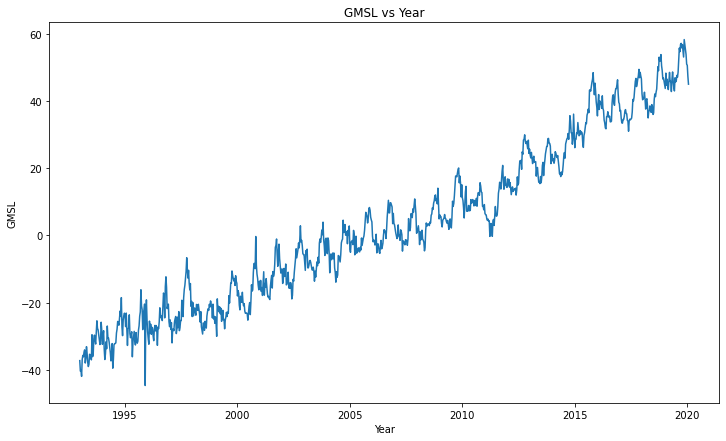

In [2]:
# Load GMSL data
sealevel = pandas.read_csv("sealevel.csv")

# Number of samples in the data set
n_samples = sealevel.shape[0]
print("Total number of observations in the sealevel data set : ", n_samples)

# Plot sea level data against time
plt.figure(figsize=(12,7))
plt.plot(sealevel['Year'], sealevel['GMSL'])
plt.title('GMSL vs Year')
plt.xlabel('Year')
plt.ylabel('GMSL')

**Q2**: The data has a clear upward trend. Before fitting an AR model to this data need to remove this trend. Explain, using one or two sentences, why this is necessary.

**A2:** Dertrending is essential to identify other potential sub-trends and patterns (ex: seasonal patterns) in the data. Removing the trend aspect from the data helps to focus on the smaller fluctuations in the data and analyze them. The main focus of AR model is to use the temporal dependencies between the data pointsat each time step for forecasting, filtering and smoothing. To achieve that, trend has to be removed and the data should attain a constant mean for better results. 

**Q3** Detrend the data following these steps:
1. Fit a straight line, $\mu_t=\theta_0 + \theta_1 u_t$ to the data based on the method of least squares. Here, $u_t$ is the time point when obervation $t$ was recorded.

    _Hint:_ You can use `lm.LinearRegression().fit(...)` from scikit-learn. Note that the inputs need to be passed as a 2D array.

    Before going on to the next step, plot your fitted line and the data in one figure.


2. Subtract the fitted line from $y_t$ for the whole data series and plot the deviations from the straight line.

**From now, we will use the detrended data in all parts of the lab.**

_Note:_ The GMSL data is recorded at regular time intervals, so that $u_{t+1} - u_t =$ const. Therefore, you can just as well use $t$ directly in the linear regression function if you prefer, $\mu_t=\theta_0 + \theta_1 t$.

**A3:**

Text(0, 0.5, 'GMSL')

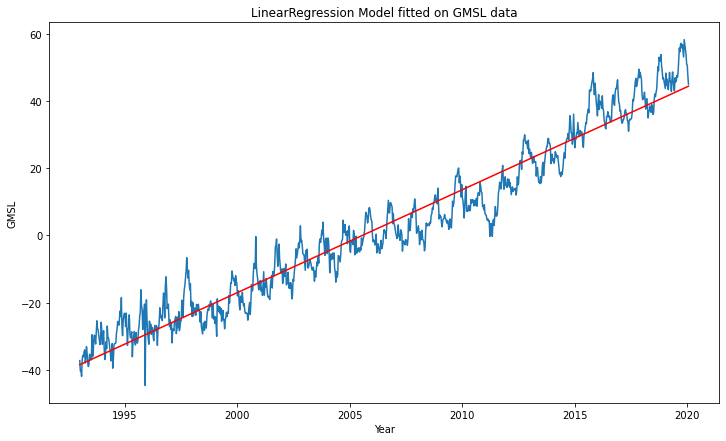

In [3]:
# Reshape the data to pass to LinearRegression().fit()
X = sealevel['Year'].values.reshape(n_samples, 1)
y = sealevel['GMSL'].values

# Fit a linear regression model to the data
sealevel_lm = lm.LinearRegression().fit(X, y)
y_pred = sealevel_lm.predict(X)

# Plot the fitted line over the actual data
plt.figure(figsize=(12,7))
plt.plot(X, y)
plt.plot(X, y_pred, color='red')
plt.title('LinearRegression Model fitted on GMSL data')
plt.xlabel('Year')
plt.ylabel('GMSL')

Text(0, 0.5, 'GMSL')

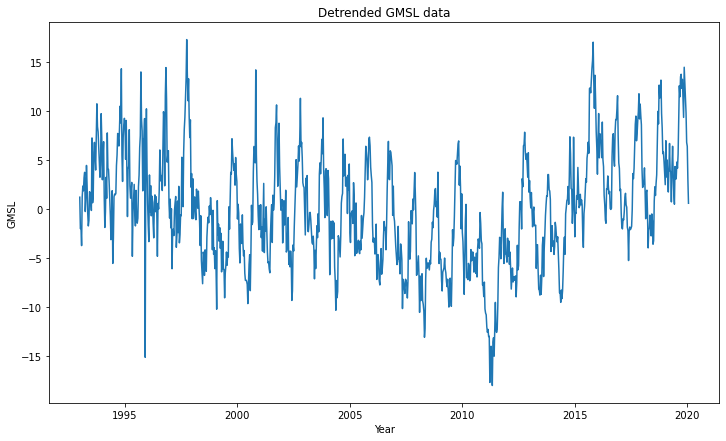

In [4]:
# Detrend the data by subtracting the fitted line from yt for the whole data series
y_detrend = y - y_pred

# Plot the fitted line over the data
plt.figure(figsize=(12,7))
plt.plot(X, y_detrend)
plt.title('Detrended GMSL data')
plt.xlabel('Year')
plt.ylabel('GMSL')

**Q4:** Split the (detrended) time series into training and validation sets. Use the values from the beginning up to the 700th time point (i.e. $y_t$ for $t=1$ to $t=700$) as your training data, and the rest of the values as your validation data. Plot the two data sets.

_Note:_ In the above, we have allowed ourselves to use all the available data (train + validation) when detrending. An alternative would be to use only the training data also when detrending the model. The latter approach is more suitable if, either:
* we view the linear detrending as part of the model choice. Perhaps we wish to compare different polynomial trend models, and evaluate their performance on the validation data, or
* we wish to use the second chunk of observations to estimate the performance of the final model on unseen data (in that case it is often referred to as "test data" instead of "validation data"), in which case we should not use these observations when fitting the model, including the detrending step.

In this laboration we consider the linear detrending as a predetermined preprocessing step and therefore allow ourselves to use the validation data when computing the linear trend.

**A4:**

Text(0, 0.5, 'GMSL')

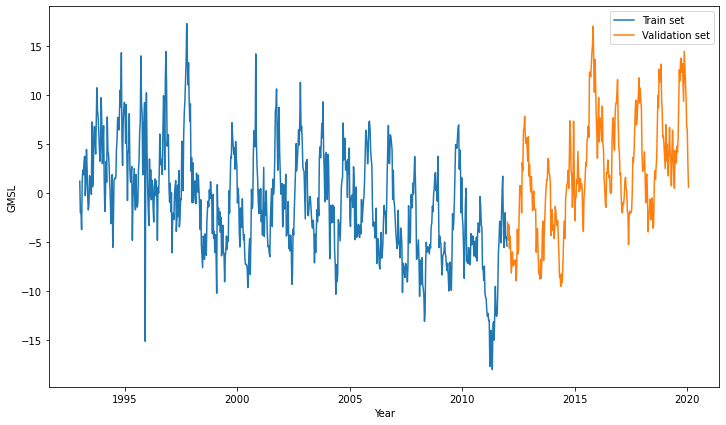

In [5]:
# Split the detrended data into train and validation sets
X_train = X[0:700]
y_train = y_detrend[0:700]

X_valid = X[700:]
y_valid = y_detrend[700:]

# Plot the two data sets
plt.figure(figsize=(12,7))
plt.plot(X_train, y_train, label='Train set')
plt.plot(X_valid, y_valid, label='Validation set')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL')

## 1.2 Fit an autoregressive model
We will now fit an AR$(p)$ model to the training data for a given value of the model order $p$.

**Q5**: Create a function that fits an AR$(p)$ model for an arbitrary value of p. Use this function to fit a model of order $p=10$ to the training data and write out (or plot) the coefficients.

_Hint:_ Since fitting an AR model is essentially just a standard linear regression we can make use of `lm.LinearRegression().fit(...)` similarly to above. You may use the template below and simply fill in the missing code.

**A5:**

In [6]:
def fit_ar(y, p):
    """Fits an AR(p) model. The loss function is the sum of squared errors from t=p+1 to t=n.

    :param y: array (n,), training data points
    :param p: int, AR model order
    :return theta: array (p,), learnt AR coefficients
    """

    # Number of training data points
    n = len(y)
    
    # Construct the regression matrix
    Phi = np.zeros(shape=(n-p, p))
    for j in range(p):
        Phi[:,j] = y[p-1-j:n-1-j]
        
        # Same as above but gives flipped theta
        #Phi[:,j] = y[j:n-p+j]
    
    # Drop the first p values from the target vector y
    yy = y[p:]  # yy = (y_{p+1}, ..., y_n)

    # Here we use fit_intercept=False since we do not want to include an intercept term in the AR model
    regr = lm.LinearRegression(fit_intercept=False)
    regr.fit(Phi,yy)

    return regr.coef_

In [7]:
# Fit an AR(10) model using simple linear regression
p = 10
theta = fit_ar(y_train, p) # theta = (theta_1, theta_2, ..., theta_p)
print("The AR coefficients : \n\n", theta)

The AR coefficients : 

 [ 0.62156052  0.10763277  0.15104657  0.1745703  -0.02184709 -0.05955406
 -0.09578106  0.07585221 -0.11175939  0.02305208]


**Q6:** Next, write a function that computes the one-step-ahead prediction of your fitted model. 'One-step-ahead' here means that in order to predict $y_t$ at $t=t_0$, we use the actual values of $y_t$ for $t<t_0$ from the data. Use your function to compute the predictions for both *training data* and *validation data*. Plot the predictions together with the data (you can plot both training and validation data in the same figure). Also plot the *residuals*.

_Hint:_ It is enought to call the predict function once, for both training and validation data at the same time.

**A6:**

In [8]:
def predict_ar_1step(theta, y_target):
    """Predicts the value y_t for t = p+1, ..., n, for an AR(p) model, based on the data in y_target using
    one-step-ahead prediction.

    :param theta: array (p,), AR coefficients, theta=(a1,a2,...,ap).
    :param y_target: array (n,), the data points used to compute the predictions.
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n) 
    """

    n = len(y_target)
    p = len(theta)
    
    # Number of steps in prediction
    m = n-p
    y_pred = np.zeros(m)
    
    # Flip the theta because y is reversed (looking ahead instead of looking back)
    theta = np.flip(theta.copy()) # theta = (theta_p, ..., theta_2, theta_1)
    for i in range(m):
        y_pred[i] = np.sum(theta * y_target[i:p+i]) # (y_{i+1}, y_{i+2}, ..., y_{i+p})
        
    return y_pred

Text(0, 0.5, 'GMSL')

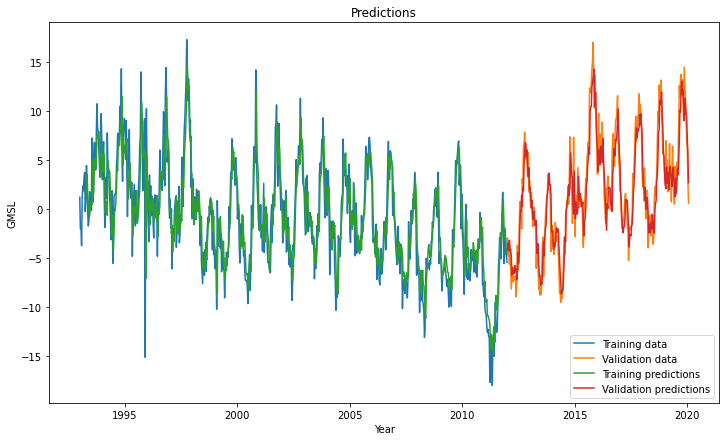

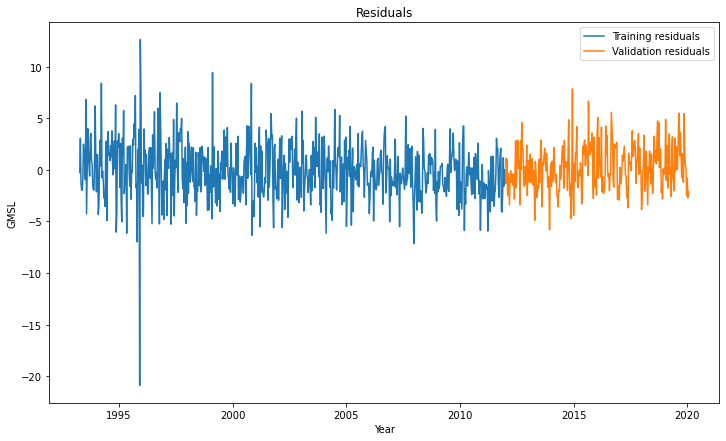

In [9]:
# Make one-step-ahead predictions from the data and compute the residuals
y = np.concatenate([y_train, y_valid])
y_pred = predict_ar_1step(theta, y)
residuals = y[p:]-y_pred

# Plot the predictions for training and validation sets 
plt.figure(figsize=(12,7))
plt.plot(X_train, y_train, label='Training data')
plt.plot(X_valid, y_valid, label='Validation data')
plt.plot(X_train[p:], y_pred[0:700-p], label='Training predictions')
plt.plot(X_valid, y_pred[700-p:], label='Validation predictions')
plt.title('Predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL')

# Residuals plot
plt.figure(figsize=(12,7))
plt.plot(X_train[p:], residuals[0:700-p], label='Training residuals')
plt.plot(X_valid, residuals[700-p:], label='Validation residuals')
plt.title('Residuals')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL')

**Q7:** Compute and plot the autocorrelation function (ACF) of the *residuals* only for the *validation data*. What conclusions can you draw from the ACF plot?

_Hint:_ You can use the function `acfplot` from the `tssltools` module, available on the course web page.

**A7:**

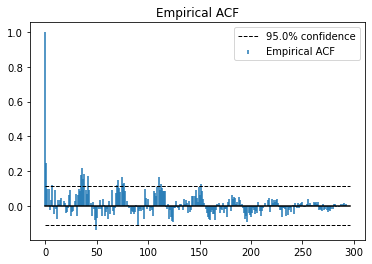

In [10]:
# Plot the residuals for validation data
acfplot(residuals[700-p:])

If the AR(10) model is accurate he ACF plot of residuals should resemble the ACF plot of white gaussian noise i.e. the empirical ACF at lag h (h>0) should be asymptotically zero for large n. But, it can be seen from the graph that several ACF values for the AR(10) model deviate significantly from zero and lie outside the 95% coverage of the asymptotic distribution of ACF for white gaussian noise. So we conclude that the AR(10) model is not the best fit for given data and that more model orders need to be evaluated to get a better fit.

## 1.3 Model validation and order selection
Above we set the model order $p=10$ quite arbitrarily. In this section we will try to find an appropriate order by validation.

**Q8**: Write a loop in which AR-models of orders from $p=2$ to $p=150$ are fitted to the data above. Plot the training and validation mean-squared errors for the one-step-ahead predictions versus the model order.

Based on your results:
- What is the main difference between the changes in training error and validation error as the order increases? 
- Based on these results, which model order would you suggest to use and why?

_Note:_ There is no obvious "correct answer" to the second question, but you still need to pick an order an motivate your choice!


**A8:**

[Text(0.5, 0, 'Model Order p'), Text(0, 0.5, 'Validation MSE')]

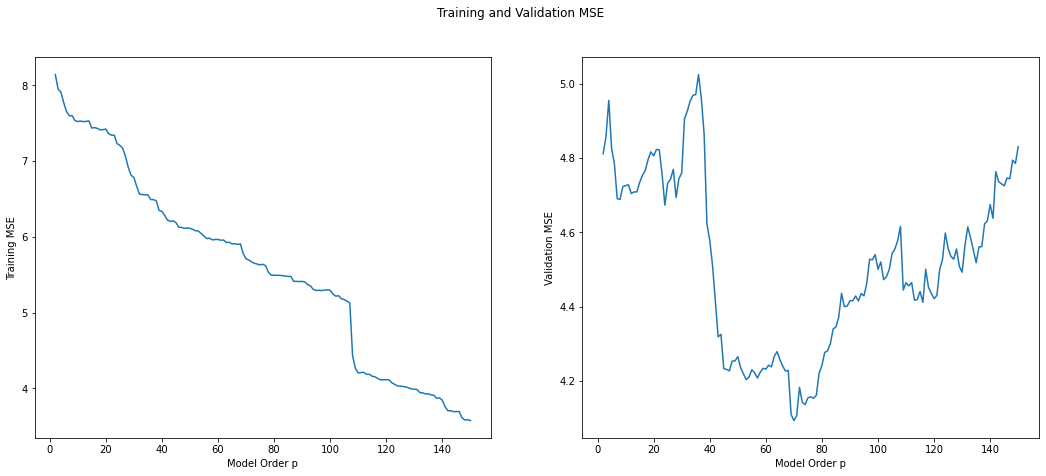

In [11]:
mse_train = list()
mse_valid = list()

for p in range(2, 151):
    # Fit an AR model of order p using simple linear regression
    theta = fit_ar(y_train, p)
    
    # Make one-step-ahead predictions from the data
    y = np.concatenate([y_train, y_valid])
    y_pred = predict_ar_1step(theta, y)
    
    # Compute the residuals
    residuals = y[p:]-y_pred
    
    # Compute the validation mean-squared errors
    mse_train.append(np.sum(residuals[0:700-p] ** 2) / len(residuals[0:700-p])) # ntrain-p terms
    mse_valid.append(np.sum(residuals[700-p:] ** 2) / len(residuals[700-p:])) # nvalid

# Plot the training and validation MSE for different model orders
fig,ax = plt.subplots(nrows=1, ncols=2, sharex='all', figsize=(18,7))
fig.suptitle('Training and Validation MSE')
ax[0].plot(range(2,151), mse_train)
ax[0].set(xlabel='Model Order p', ylabel='Training MSE')
ax[1].plot(range(2,151), mse_valid)
ax[1].set(xlabel='Model Order p', ylabel='Validation MSE')

For one-step ahead predictions, we see that the training MSE decreases consistently as the model order p increases whereas the validation MSE plot is not so smooth. We see a dip in the validation MSE for model order between p=45 and p=75 and then increases again for higher model orders which could suggest overfitting. The training MSE for the model orders between p=45 and p=75 is higher than the validation MSE. But we chose the model order p=70 as the validation MSE is low as well as the training MSE is reasonably low and the model is not too complicated.

**Q9:** Based on the chosen model order, compute the residuals of the one-step-ahead predictions on the *validation data*. Plot the autocorrelation function of the residuals. What conclusions can you draw? Compare to the ACF plot generated above for p=10.

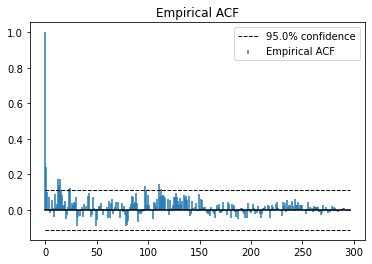

In [12]:
# Fit an AR(70) model using simple linear regression
p = 70
theta = fit_ar(y_train, p)

# Make one-step-ahead predictions on the validation data and compute the residuals
y = np.concatenate([y_train[700-p:], y_valid])
y_pred = predict_ar_1step(theta, y)
residuals_valid = y_valid-y_pred

# Plot the residuals for validation data
acfplot(residuals_valid)

The ACF plot for AR(70) model looks better than the one for AR(10) model. As can be seen from the graph now that fewer ACF values deviate from zero or lie outside the 95% coverage of white gaussian noise ACF. It is still not the best fit but is better than the simpler AR models.

## 1.4 Long-range predictions
So far we have only considered one-step-ahead predictions. However, in many practical applications it is of interest to use the model to predict further into the future. For intance, for the sea level data studied in this laboration, it is more interesting to predict the level one year from now, and not just 10 days ahead (10 days = 1 time step in this data).

**Q10**: 
Write a function that simulates the value of an AR($p$) model $m$ steps into the future, conditionally on an initial sequence of data points. Specifically, given $y_{1:n}$ with $n\geq p$ the function/code should predict the values

\begin{align}
    \hat y_{t|n} &= \mathbb{E}[y_{t} | y_{1:n}], &t &=n+1,\dots,n+m.
\end{align}

Use this to predict the values for the validation data ($y_{701:997}$) conditionally on the training data ($y_{1:700}$) and plot the result.

_Hint:_ Use the pseudo-code derived at the first pen-and-paper session.

**A10:**

In [13]:
def simulate_ar(y, theta, m):
    """Simulates an AR(p) model for m steps, with initial condition given by the last p values of y
    
    :param y: array (n,) with n>=p. The last p values are used to initialize the simulation.
    :param theta: array (p,). AR model parameters,
    :param m: int, number of time steps to simulate the model for.
    """

    p = len(theta)    
    y_sim = np.zeros(m)
    phi = np.flip(y[-p:].copy()) # (y_{n-1}, ..., y_{n-p})^T - note that y[ntrain-1] is the last training data point
    
    for i in range(m):
        # Make the one-step ahead prediction
        y_sim[i] = np.dot(theta, phi) # add np.random.normal(0,1)
        
        # Add the prediction to last p observations and remove the 
        phi = np.concatenate([y_sim[i:i+1], phi[:-1]])
    
    return y_sim

Text(0, 0.5, 'Validation MSE')

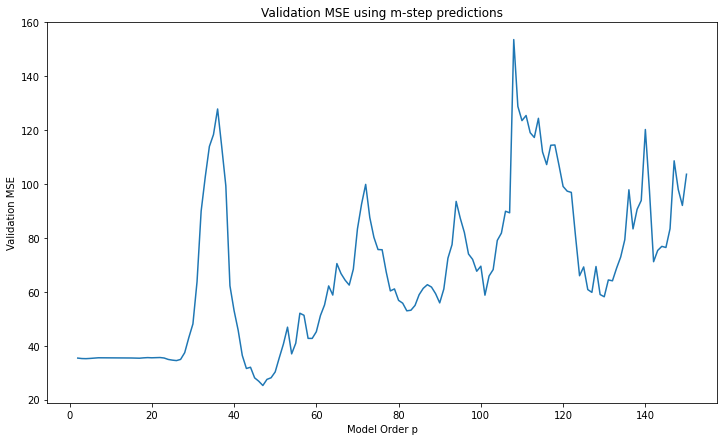

In [14]:
# Determine the optimum model order p for m-step predictions
mse_valid = list()

for p in range(2, 151):
    # Fit an AR model of order p using simple linear regression
    theta = fit_ar(y_train, p)
    
    # Make m-step predictions from the data
    y_pred = simulate_ar(y_train, theta, m=len(y_valid))
    
    # Compute the residuals
    residuals = y_valid-y_pred
    
    # Compute the validation mean-squared errors
    mse_valid.append(np.sum(residuals ** 2) / len(residuals)) # nvalid

# Plot the training and validation MSE for different model orders
plt.figure(figsize=(12,7))
plt.title('Validation MSE using m-step predictions')
plt.plot(range(2,151), mse_valid)
plt.xlabel('Model Order p')
plt.ylabel('Validation MSE')

For m-step ahead predictions, we plot the validation MSE to re-evaluate the optimum model order p and concluded that model order p=50 is a better choice for m-step-ahead predictions.

Text(0, 0.5, 'GMSL')

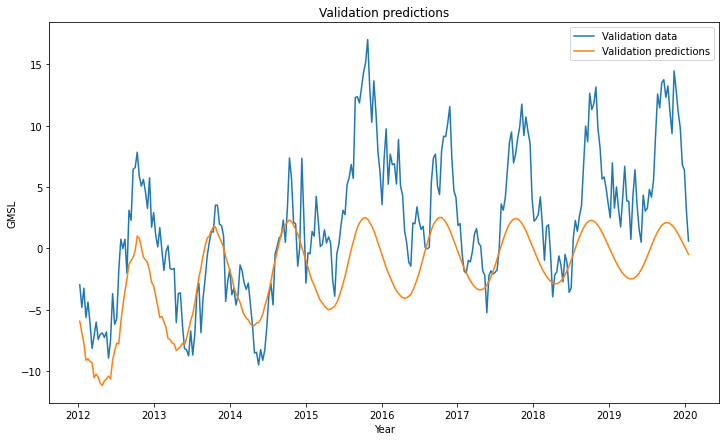

In [15]:
# Fit an AR(50) model using simple linear regression
p = 50
theta = fit_ar(y_train, p)

# Make m-step predictions on the validation data
m = len(y_valid)
y_valid_pred = simulate_ar(y_train, theta, m)

# Plot the validation data and its predictions
plt.figure(figsize=(12,7))
plt.plot(X_valid, y_valid, label='Validation data')
plt.plot(X_valid, y_valid_pred, label='Validation predictions')
plt.title('Validation predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL')

We see that the m-step predictions become poorer as the time grows i.e. the GMSL values predicted at initial time steps are close the actuals and the predictions too far into the future are not close to the actual values. This may be explained by the fact that the AR model makes the initial predictions using observed data whereas with growing time the far-future predictions are based on more simulated values than actual observations in the data and the quality of the predictions drops.

**Q11:** Using the same function as above, try to simulate the process for a large number of time steps (say, $m=2000$). You should see that the predicted values eventually converge to a constant prediction of zero. Is this something that you would expect to see in general? Explain the result.

**A11:**

Text(0, 0.5, 'GMSL')

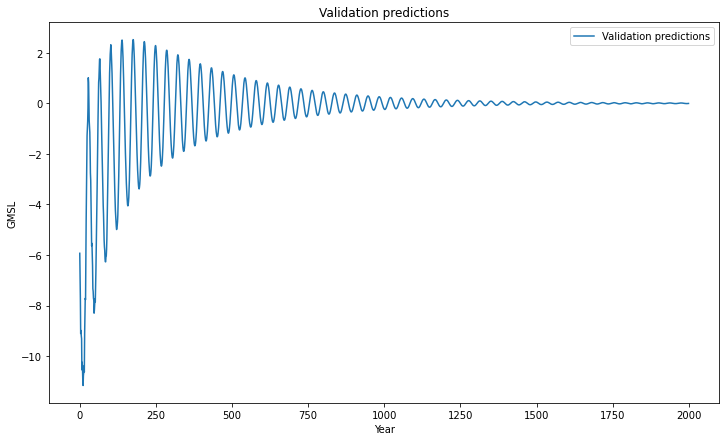

In [16]:
# Make m-step predictions on the validation data
m = 2000
y_pred = simulate_ar(y_train, theta, m)

# Plot the validation data and its predictions
plt.figure(figsize=(12,7))
plt.plot(y_pred, label='Validation predictions')
plt.title('Validation predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL')

Yes the predicted values eventually converged to a constant prediction of zero. The result was a bit surprising at first. But this may be explained by the absence of the random noise component from the model when used for predictions. Due to which every new prediction becomes more and more similar to its previous prediction and eventually all prdictions converge to the mean of the detrended dataset which is zero. We verified that this behaviour changes when we add the random white gaussian noise component in the prediction step in simulate_ar() method.

## 1.5 Nonlinear AR model
 In this part, we switch to a nonlinear autoregressive (NAR) model, which is based on a feedforward neural network. This means that in this model the recursive equation for making predictions is still in the form $\hat y_t=f_\theta(y_{t-1},...,y_{t-p})$, but this time $f$ is a nonlinear function learned by the neural network. Fortunately almost all of the work for implementing the neural network and training it is handled by the `scikit-learn` package with a few lines of code, and we just need to choose the right structure, and prepare the input-output data.   

**Q12**: Construct a NAR($p$) model with a feedforward (MLP) network, by using the `MLPRegressor` class from `scikit-learn`. Set $p$ to the same value as you chose for the linear AR model above. Initially, you can use an MLP with a single hidden layer consisting of 10 hidden neurons. 
Train it using the same training data as above and plot the one-step-ahead predictions as well as the residuals, on both the training and validation data. 

_Hint:_ You will need the methods `fit` and `predict` of `MLPRegressor`. Read the user guide of `scikit-learn` for more details. Recall that a NAR model is conceptuall very similar to an AR model, so you can reuse part of the code from above.

**A12:**

In [17]:
def simulate_nar(y_train, y_valid, p, hidden_size=(20,), act='relu', solver='adam', max_iter=200):
    """Predicts the value y_t for t = p+1, ..., n, for an NAR(p) model, based on the training data in y_train using
    one-step-ahead prediction.

    :param y_train: array (ntrain,) with n>=p. the data points used to learn the NAR model parameters and make predictions.
    :param y_valid: array (nvalid,) the data points to make predictions on 
    :param p: model order p
    :return y_pred: array (n-p,), the one-step predictions (\hat y_{p+1}, ...., \hat y_n)     
    """

    # Build the nonlinear autoregressive (NAR) model
    mlp = MLPRegressor(hidden_layer_sizes=hidden_size, activation=act, solver=solver, max_iter=max_iter)

    # Number of training data points
    ntrain = len(y_train)

    # Construct the regression matrix to train and fit the model
    Phi_train = np.zeros(shape=(ntrain-p, p))
    for j in range(p):
        Phi_train[:,j] = y_train[j:ntrain-p+j]
    
    # Drop the first p values from the target vector y
    yy_train = y_train[p:]  # yy = (y_{p+1}, ..., y_n)
    
    # Train the model using train data
    mlp.fit(X=Phi_train, y=yy_train)

    # Make one-step-ahead predictions on training data
    y_pred_train = mlp.predict(Phi_train)
    
    # Number of training data points    
    nvalid = len(y_valid)
      
    # Take the last p observations from the training data to start predicting from the first validation data point
    y = np.concatenate([y_train[ntrain-p:], y_valid])
    
    # Construct the input matrix to predict on validation data 
    Phi_valid = np.zeros(shape=(nvalid, p))
    for j in range(p):
        Phi_valid[:,j] = y[j:nvalid+j]
        
    # Make one-step-ahead predictions on training data    
    y_pred_valid = mlp.predict(Phi_valid)

    # Calculate residuals for training and validation data
    residuals_train = y_train[p:] - y_pred_train
    residuals_valid = y_valid - y_pred_valid
    
    return y_pred_train, y_pred_valid, residuals_train, residuals_valid

c:\work\tssl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0, 0.5, 'GMSL')

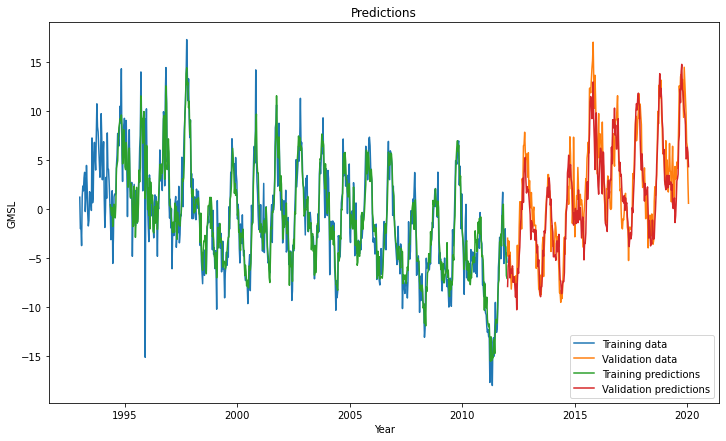

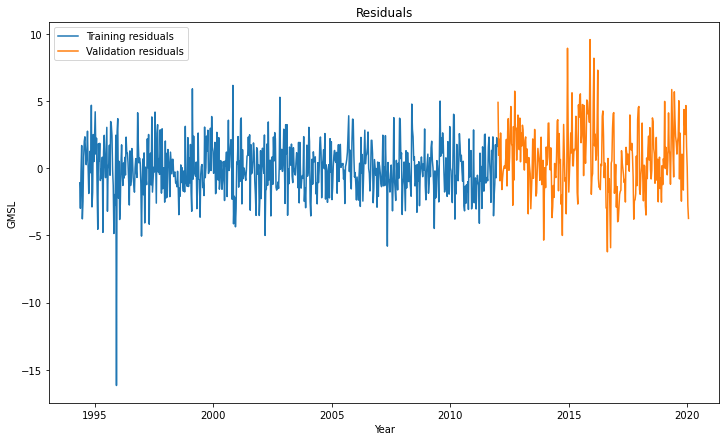

In [18]:
p = 50
y_pred_train, y_pred_valid, res_train, res_valid = simulate_nar(y_train, y_valid, p)

# Plot the predictions for training and validation sets 
plt.figure(figsize=(12,7))
plt.plot(X_train, y_train, label='Training data')
plt.plot(X_valid, y_valid, label='Validation data')
plt.plot(X_train[p:], y_pred_train, label='Training predictions')
plt.plot(X_valid, y_pred_valid, label='Validation predictions')
plt.title('Predictions')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL')

# Residuals plot
plt.figure(figsize=(12,7))
plt.plot(X_train[p:], res_train, label='Training residuals')
plt.plot(X_valid, res_valid, label='Validation residuals')
plt.title('Residuals')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL')

**Q13:** Try to expirement with different choices for the hyperparameters of the network (e.g. number of hidden layers and units per layer, activation function, etc.) and the optimizer (e.g. `solver` and `max_iter`).

Are you satisfied with the results? Why/why not? Discuss what the limitations of this approach might be.

**A13:**

c:\work\tssl\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Text(0, 0.5, 'GMSL')

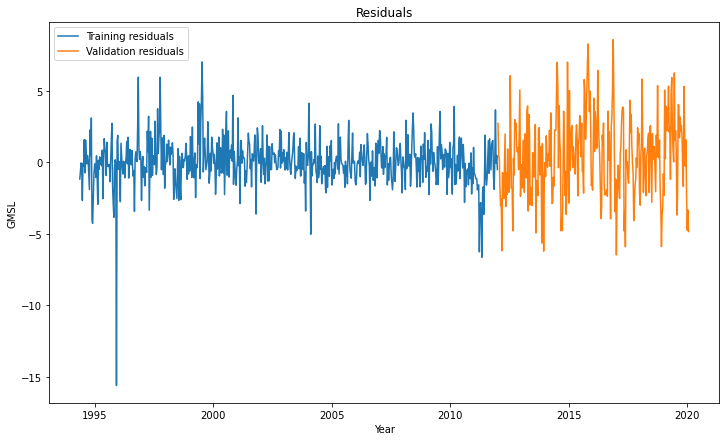

In [19]:
# Different hyperparameters
p = 50
y_pred_train, y_pred_valid, res_train, res_valid = simulate_nar(
    y_train, y_valid, p, hidden_size=(20, 30), act='tanh', solver='adam', max_iter=200)

# Residuals plot
plt.figure(figsize=(12,7))
plt.plot(X_train[p:], res_train, label='Training residuals')
plt.plot(X_valid, res_valid, label='Validation residuals')
plt.title('Residuals')
plt.legend()
plt.xlabel('Year')
plt.ylabel('GMSL')

Increasing the number of hidden layers/units per layer with tanh activation improved the predictions to some extent and the residuals became smaller in magnitude. Increasing the number of layers and layer size beyond a certain point caused the NAR(p) model to overfit to the training data and perform poorly on the validation dataset. The training residuals decreased in magnitude while the validation residuals increased. Increasing the number of iterations had a similar effect of overfitting the model to the training data.  

The results are not very satisfying because we see that the magnitude of the residuals in most cases are almost in the same order as that of the data which indicates that the model is not consistant in making good predictions. This could be due to the fact that even though the NAR(p) model captures the more complex temporal dependencies in the data compared to the linear AR(p) models, its receptive field is still limited to p time steps i.e. only takes into account the last p steps while making predictions.